<a href="https://colab.research.google.com/github/chakshu-dhannawat/3D-Reconstruction/blob/main/Tiny_Nerf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***This method is based on implementing Neural Radiance fields. It generated 3d output after taking input as multiple 2d images and their camera orientations/poses/angles at which those 2d images were taken.***

##Tiny NeRF
This is a simplied version of the method presented in *NeRF: Representing Scenes as Neural Radiance Fields for View Synthesis*

[Project Website](http://www.matthewtancik.com/nerf)

[arXiv Paper](https://arxiv.org/abs/2003.08934)

[Full Code](github.com/bmild/nerf)

Components not included in the notebook
*   5D input including view directions
*   Hierarchical Sampling



In [ ]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    %tensorflow_version 1.x

import os, sys
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

from tqdm import tqdm_notebook as tqdm
import numpy as np
import matplotlib.pyplot as plt

TensorFlow 1.x selected.


In [ ]:
if not os.path.exists('tiny_nerf_data.npz'):
    !wget http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz

--2022-06-01 09:21:52--  http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz
Resolving cseweb.ucsd.edu (cseweb.ucsd.edu)... 132.239.8.30
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cseweb.ucsd.edu//~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz [following]
--2022-06-01 09:21:52--  https://cseweb.ucsd.edu//~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12727482 (12M)
Saving to: ‘tiny_nerf_data.npz’

tiny_nerf_data.npz  100%[===================>]  12.14M  7.35MB/s    in 1.7s    

2022-06-01 09:21:55 (7.35 MB/s) - ‘tiny_nerf_data.npz’ saved [12727482/12727482]



# Load Input Images and Poses

(106, 100, 100, 3) (106, 4, 4) 138.88887889922103


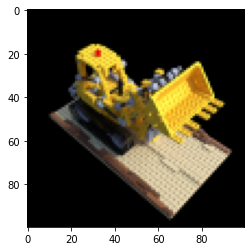

In [ ]:
data = np.load('tiny_nerf_data.npz')
images = data['images']
poses = data['poses']
focal = data['focal']
H, W = images.shape[1:3]
print(images.shape, poses.shape, focal)

testimg, testpose = images[101], poses[101]
images = images[:100,...,:3]
poses = poses[:100]

plt.imshow(testimg)
plt.show()

# Optimize NeRF

In [ ]:


def posenc(x):
  rets = [x]
  for i in range(L_embed):
    for fn in [tf.sin, tf.cos]:
      rets.append(fn(2.**i * x))
  return tf.concat(rets, -1)

L_embed = 6
embed_fn = posenc
# L_embed = 0
# embed_fn = tf.identity

def init_model(D=8, W=256):
    relu = tf.keras.layers.ReLU()    
    dense = lambda W=W, act=relu : tf.keras.layers.Dense(W, activation=act)

    inputs = tf.keras.Input(shape=(3 + 3*2*L_embed)) 
    outputs = inputs
    for i in range(D):
        outputs = dense()(outputs)
        if i%4==0 and i>0:
            outputs = tf.concat([outputs, inputs], -1)
    outputs = dense(4, act=None)(outputs)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model


def get_rays(H, W, focal, c2w):
    i, j = tf.meshgrid(tf.range(W, dtype=tf.float32), tf.range(H, dtype=tf.float32), indexing='xy')
    dirs = tf.stack([(i-W*.5)/focal, -(j-H*.5)/focal, -tf.ones_like(i)], -1)
    rays_d = tf.reduce_sum(dirs[..., np.newaxis, :] * c2w[:3,:3], -1)
    rays_o = tf.broadcast_to(c2w[:3,-1], tf.shape(rays_d))
    return rays_o, rays_d



def render_rays(network_fn, rays_o, rays_d, near, far, N_samples, rand=False):

    def batchify(fn, chunk=1024*32):
        return lambda inputs : tf.concat([fn(inputs[i:i+chunk]) for i in range(0, inputs.shape[0], chunk)], 0)
    
    # Compute 3D query points
    z_vals = tf.linspace(near, far, N_samples) 
    if rand:
      z_vals += tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples
    pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals[...,:,None]
    
    # Run network
    pts_flat = tf.reshape(pts, [-1,3])
    pts_flat = embed_fn(pts_flat)
    raw = batchify(network_fn)(pts_flat)
    raw = tf.reshape(raw, list(pts.shape[:-1]) + [4])
    
    # Compute opacities and colors
    sigma_a = tf.nn.relu(raw[...,3])
    rgb = tf.math.sigmoid(raw[...,:3]) 
    
    # Do volume rendering
    dists = tf.concat([z_vals[..., 1:] - z_vals[..., :-1], tf.broadcast_to([1e10], z_vals[...,:1].shape)], -1) 
    alpha = 1.-tf.exp(-sigma_a * dists)  
    weights = alpha * tf.math.cumprod(1.-alpha + 1e-10, -1, exclusive=True)
    
    rgb_map = tf.reduce_sum(weights[...,None] * rgb, -2) 
    depth_map = tf.reduce_sum(weights * z_vals, -1) 
    acc_map = tf.reduce_sum(weights, -1)

    return rgb_map, depth_map, acc_map

Here we optimize the model. We plot a rendered holdout view and its PSNR every 50 iterations.

0 0.03381596565246582 secs per iter


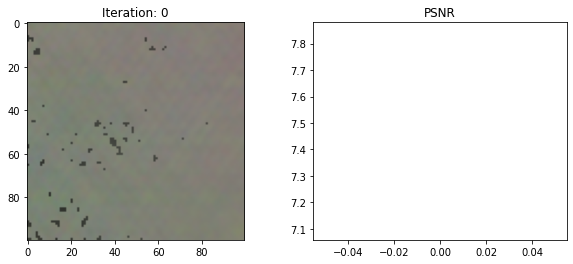

25 0.7163048458099365 secs per iter


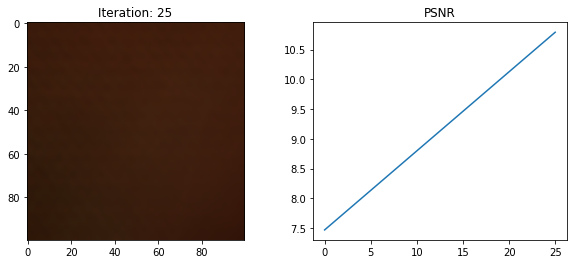

50 0.727608413696289 secs per iter


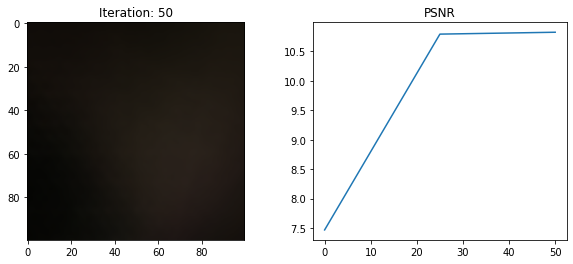

75 0.7316064739227295 secs per iter


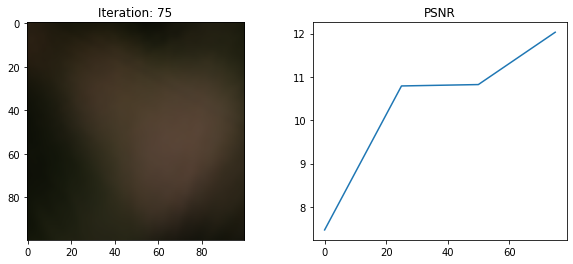

100 0.700007905960083 secs per iter


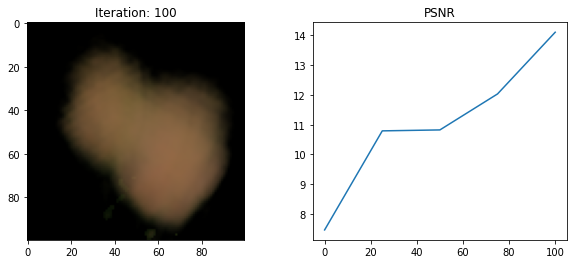

125 0.6825465106964111 secs per iter


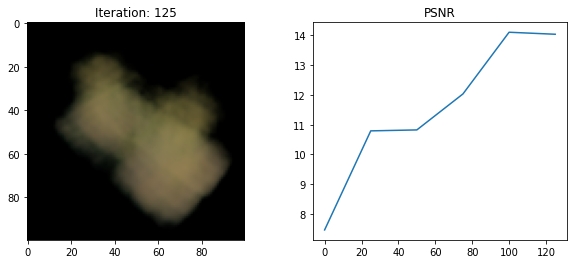

150 0.6804029750823974 secs per iter


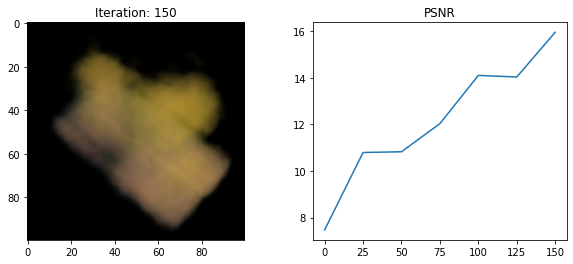

175 0.6862181568145752 secs per iter


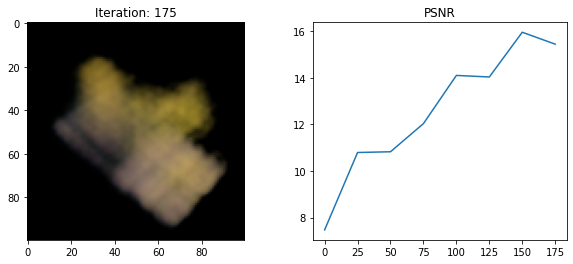

200 0.6863220310211182 secs per iter


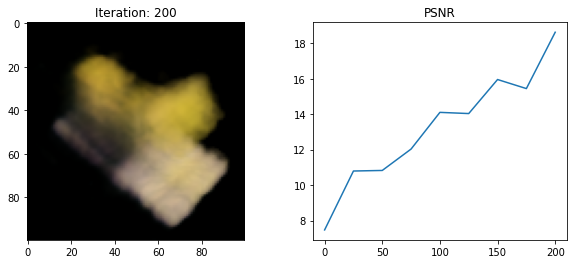

225 0.6863026142120361 secs per iter


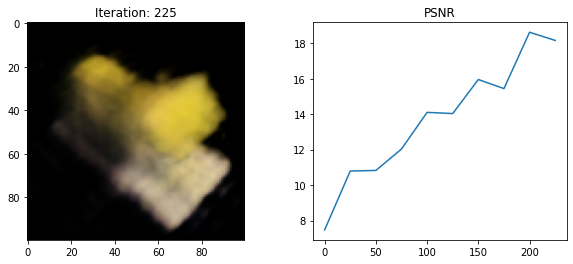

250 0.6873535060882568 secs per iter


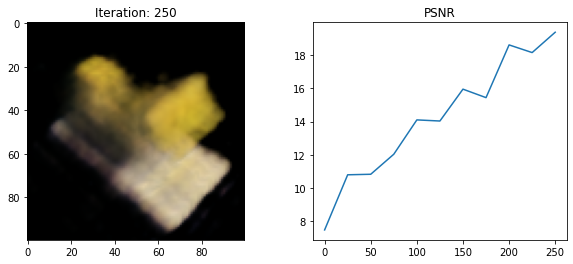

275 0.6825198364257813 secs per iter


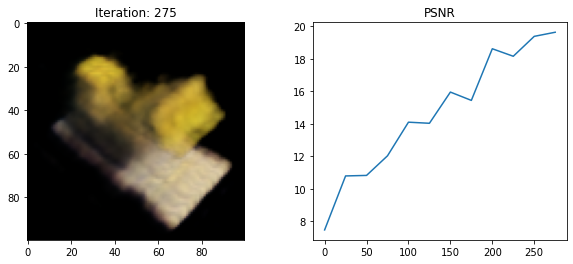

300 0.684004716873169 secs per iter


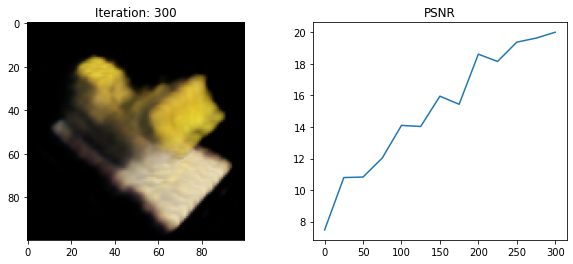

325 0.6831328296661376 secs per iter


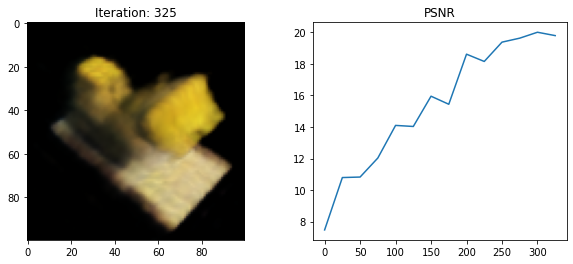

350 0.6840974426269532 secs per iter


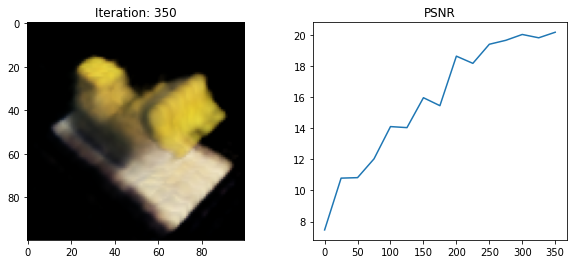

375 0.6854556560516357 secs per iter


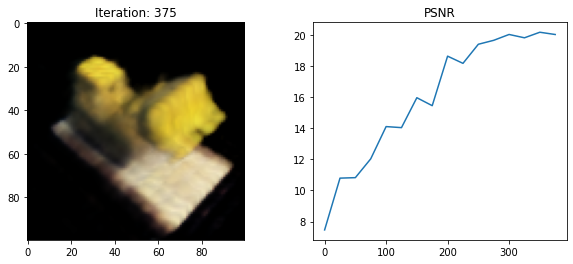

400 0.6821972560882569 secs per iter


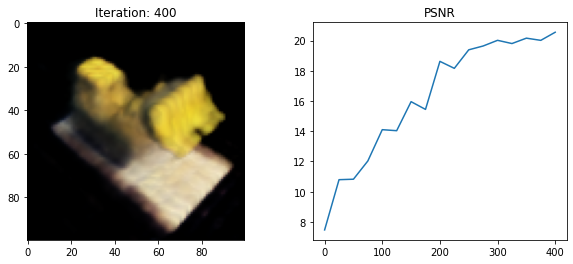

425 0.6801803207397461 secs per iter


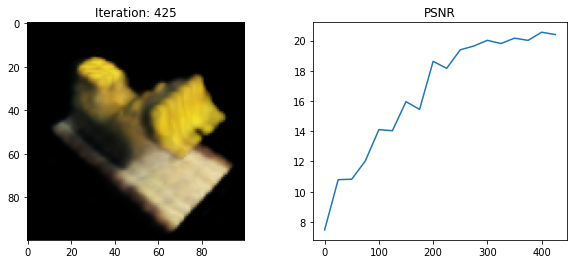

450 0.6810389232635498 secs per iter


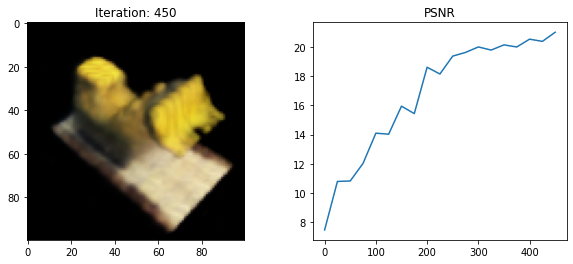

475 0.6806698989868164 secs per iter


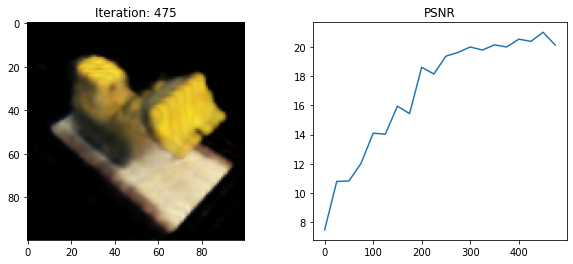

500 0.6844438362121582 secs per iter


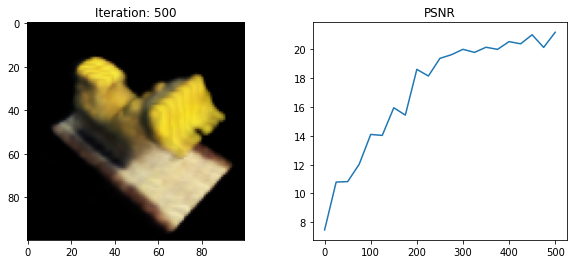

525 0.6826264190673829 secs per iter


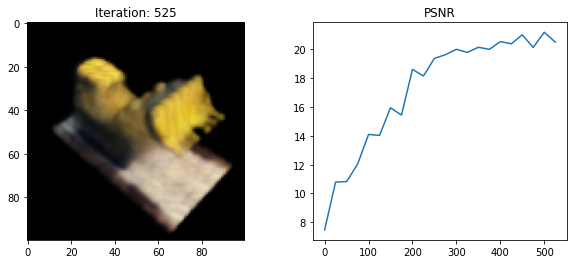

550 0.6809610462188721 secs per iter


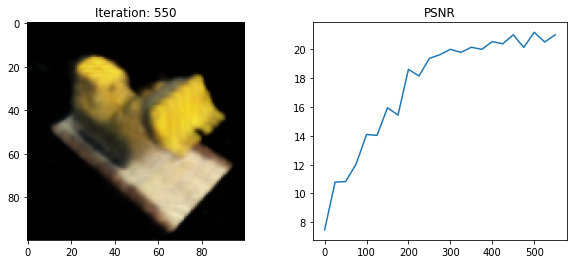

575 0.6836675834655762 secs per iter


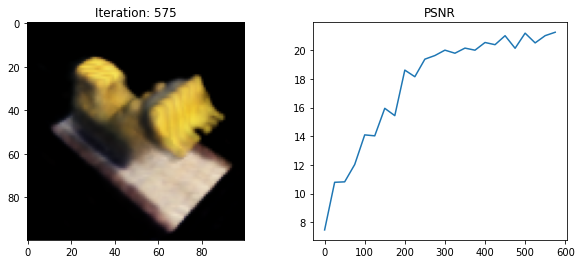

600 0.6822630310058594 secs per iter


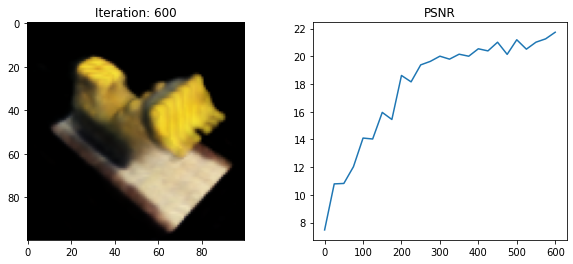

625 0.684118013381958 secs per iter


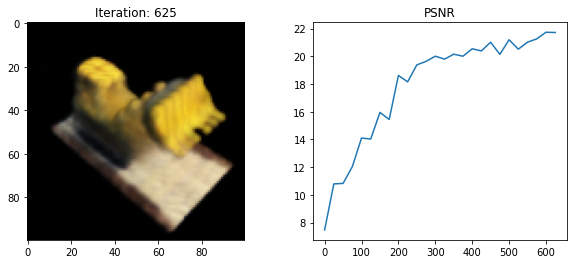

650 0.6801571846008301 secs per iter


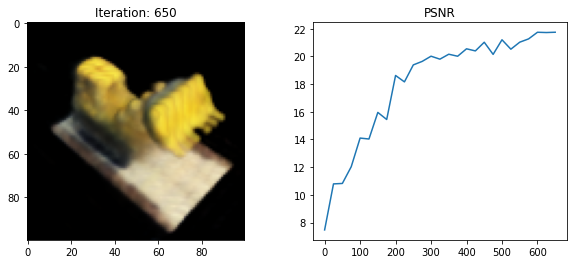

675 0.6824428558349609 secs per iter


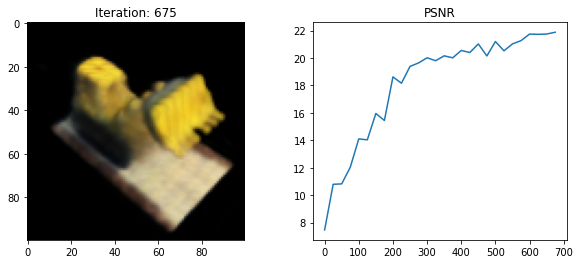

700 0.6797886371612549 secs per iter


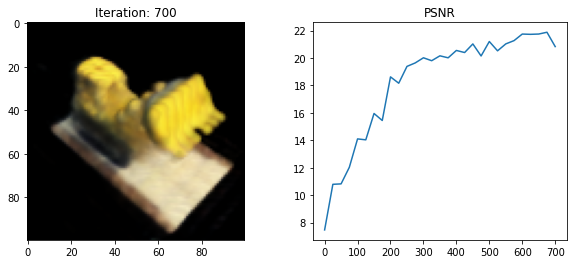

725 0.6823910808563233 secs per iter


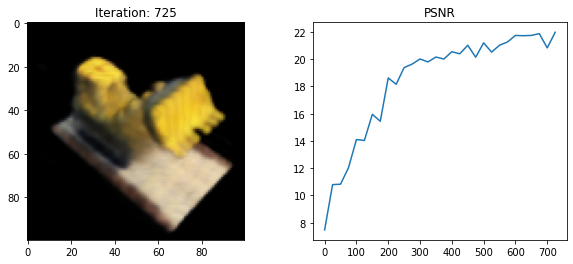

750 0.6846540832519531 secs per iter


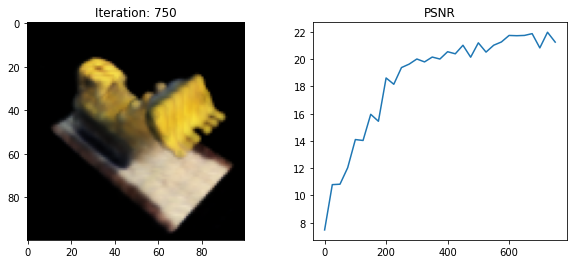

775 0.6807647895812988 secs per iter


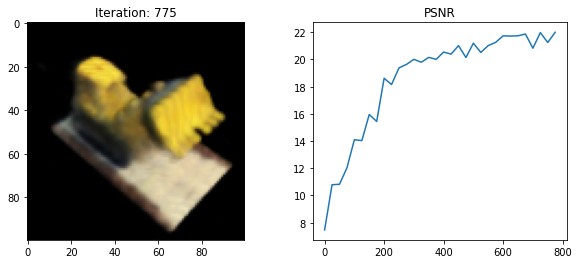

800 0.680813512802124 secs per iter


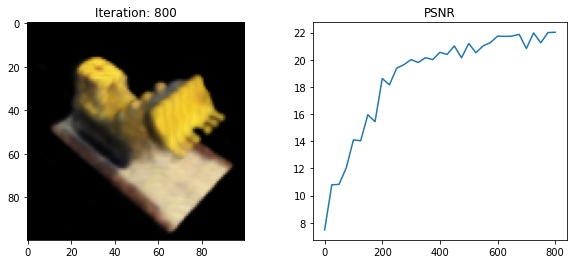

825 0.6814882373809814 secs per iter


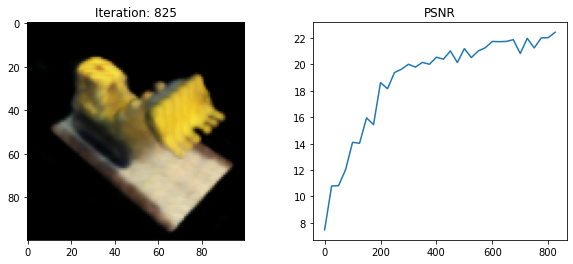

850 0.680776948928833 secs per iter


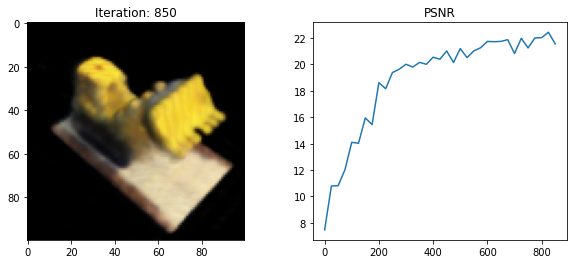

875 0.6844850730895996 secs per iter


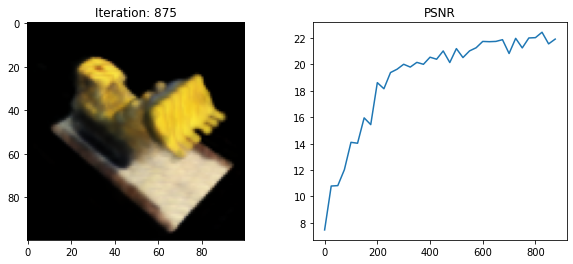

900 0.6805377292633057 secs per iter


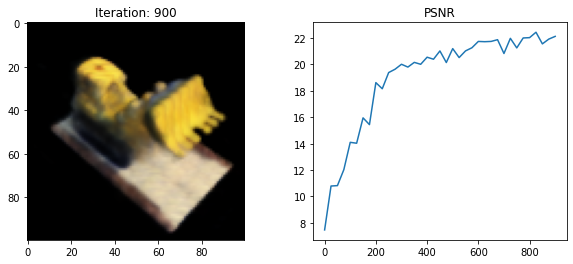

925 0.6806686115264893 secs per iter


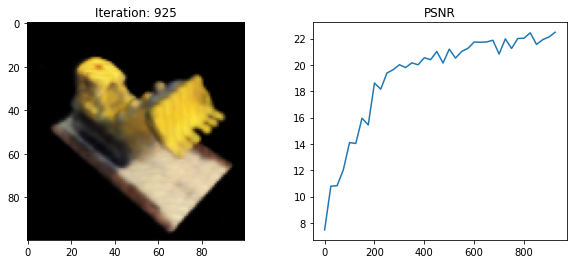

950 0.6811031055450439 secs per iter


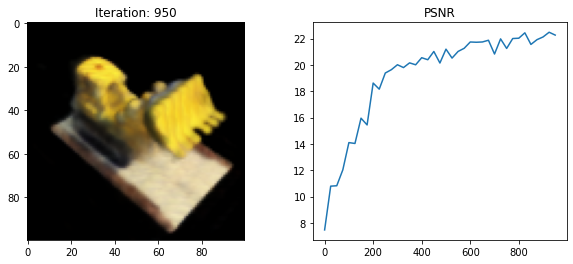

975 0.6812714767456055 secs per iter


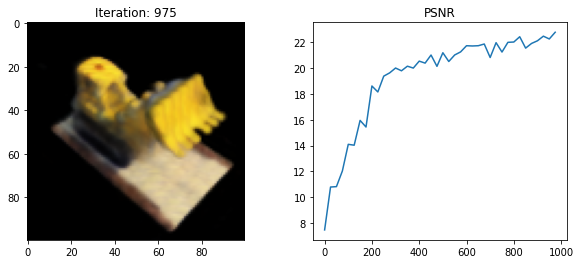

1000 0.6847214126586914 secs per iter


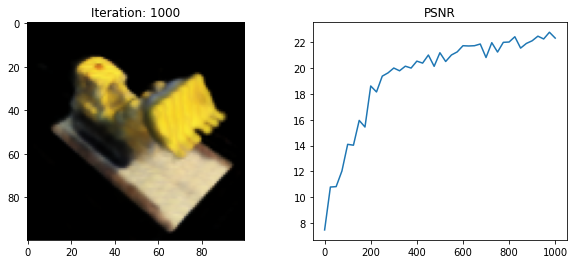

1025 0.6824896717071534 secs per iter


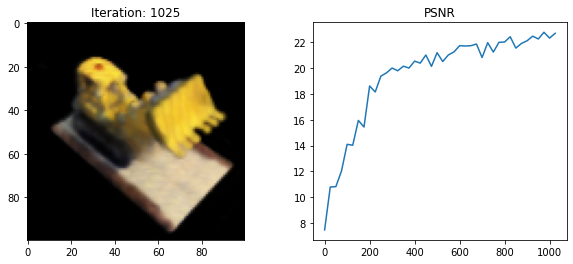

1050 0.6818385410308838 secs per iter


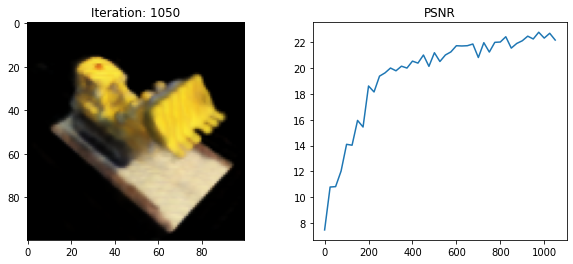

1075 0.6815770435333252 secs per iter


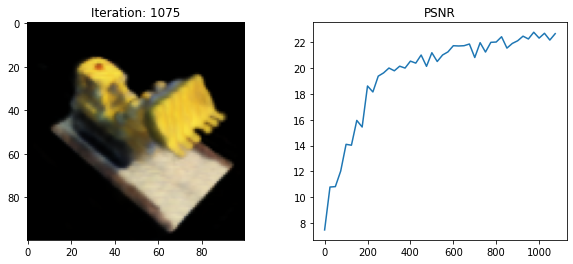

1100 0.6812126350402832 secs per iter


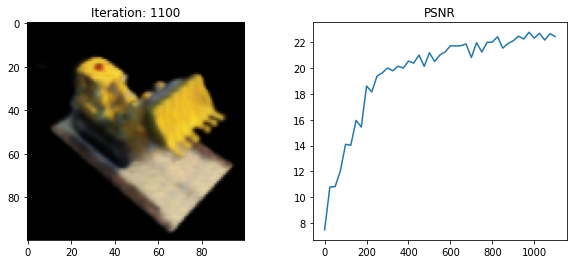

1125 0.683919792175293 secs per iter


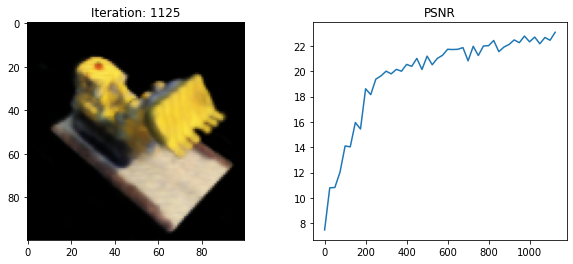

1150 0.6808496189117431 secs per iter


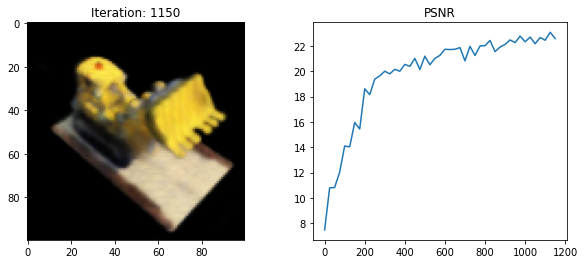

1175 0.6795405673980713 secs per iter


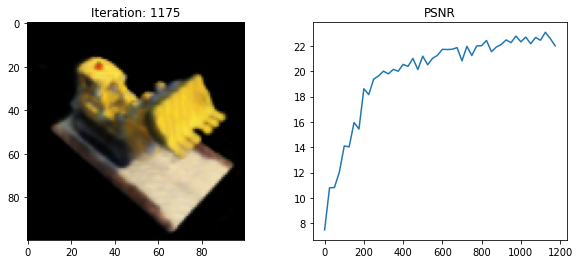

1200 0.6818343830108643 secs per iter


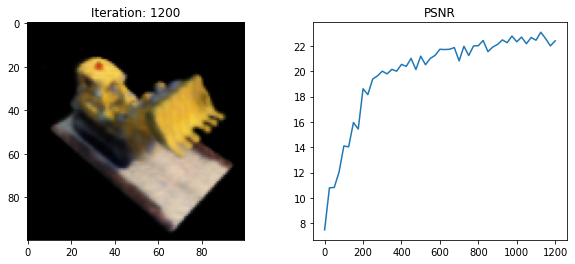

1225 0.6811118125915527 secs per iter


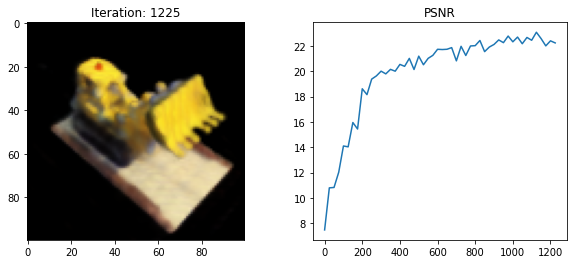

1250 0.6827217197418213 secs per iter


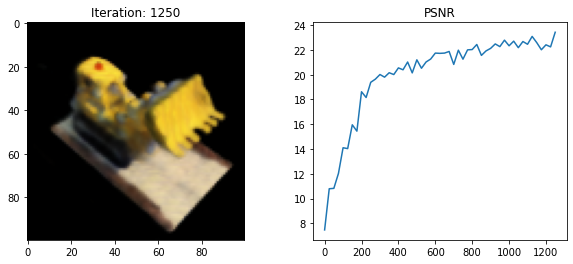

1275 0.6811297035217285 secs per iter


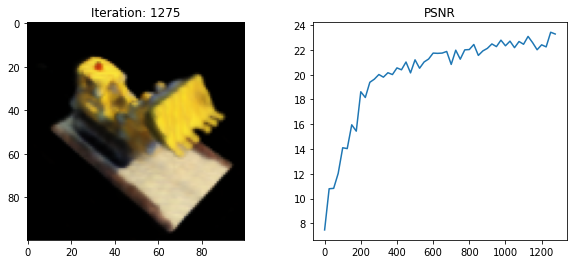

1300 0.6813511371612548 secs per iter


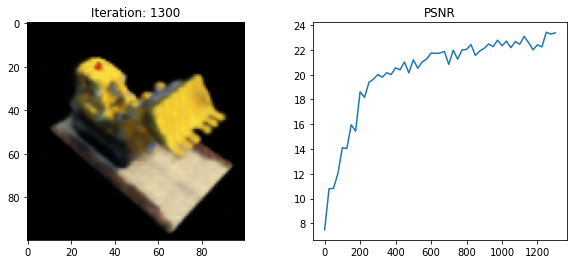

1325 0.6823727703094482 secs per iter


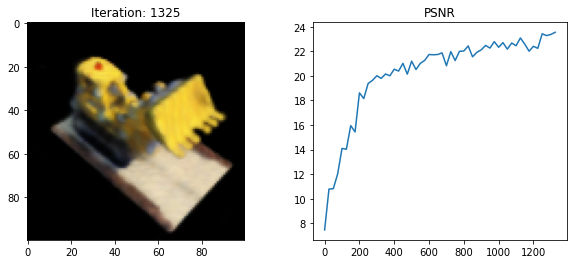

1350 0.6816025066375733 secs per iter


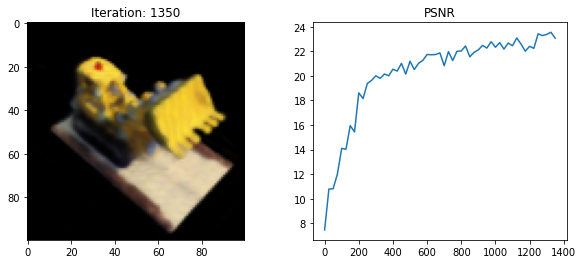

1375 0.6868511581420899 secs per iter


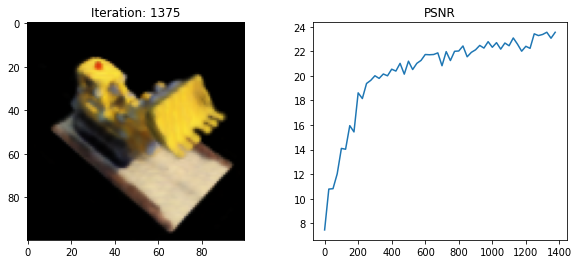

1400 0.6799659252166748 secs per iter


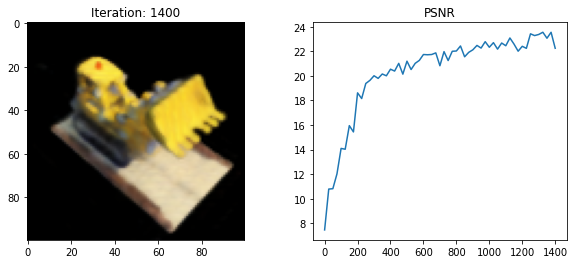

1425 0.6799850940704346 secs per iter


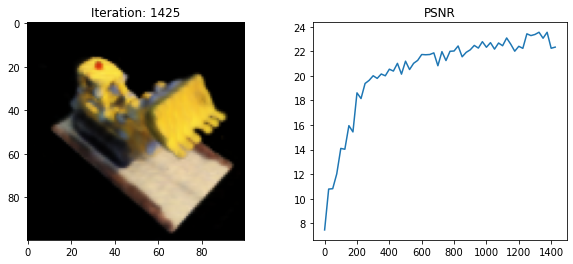

1450 0.6818048381805419 secs per iter


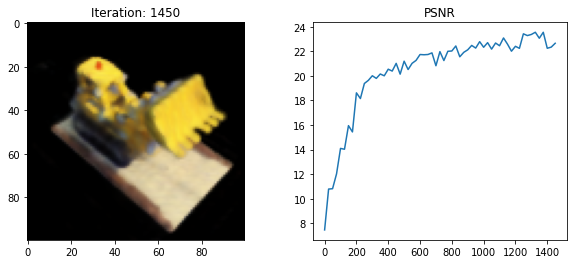

1475 0.6816599178314209 secs per iter


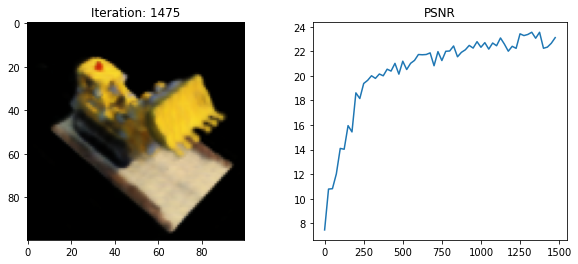

1500 0.6854810428619384 secs per iter


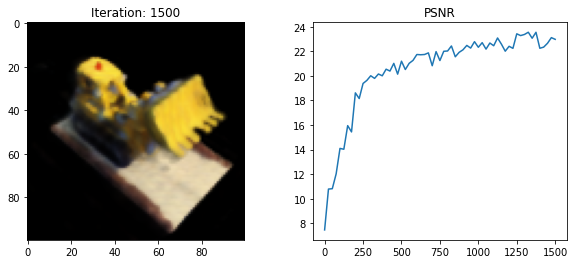

1525 0.6810583305358887 secs per iter


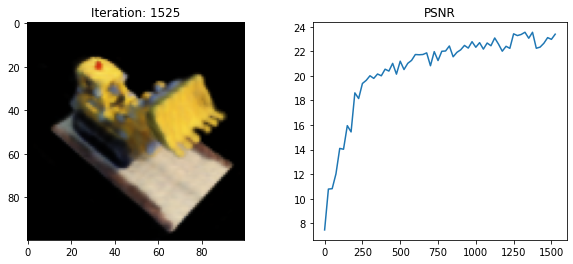

1550 0.683862247467041 secs per iter


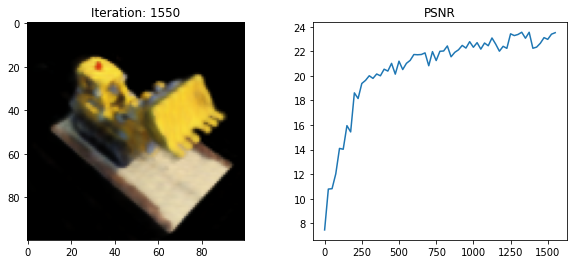

1575 0.6864724826812744 secs per iter


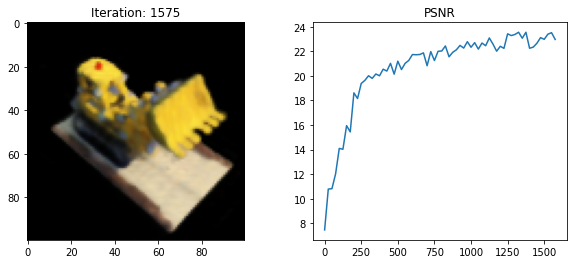

1600 0.68358304977417 secs per iter


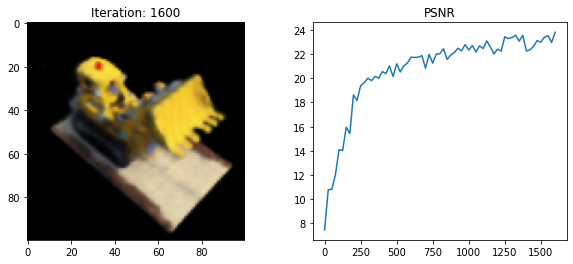

1625 0.6882881641387939 secs per iter


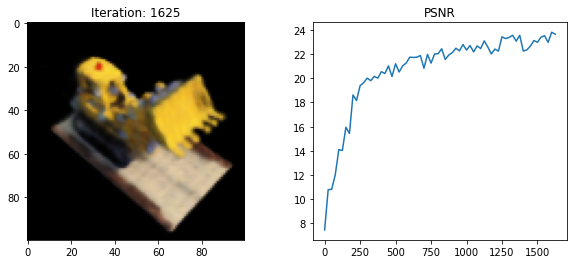

1650 0.6828745365142822 secs per iter


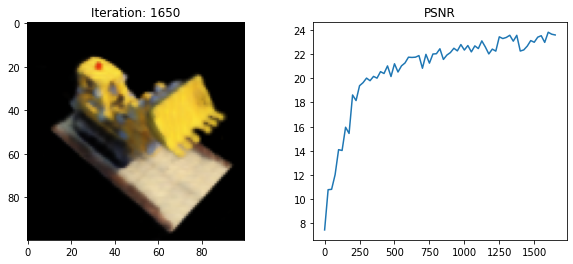

1675 0.6816681671142578 secs per iter


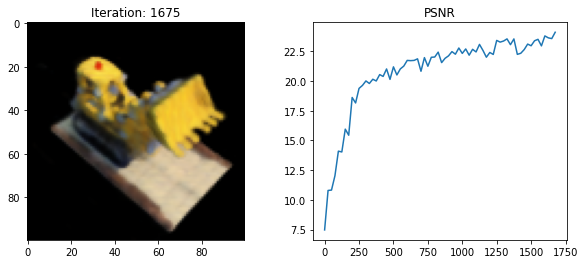

1700 0.6821383476257324 secs per iter


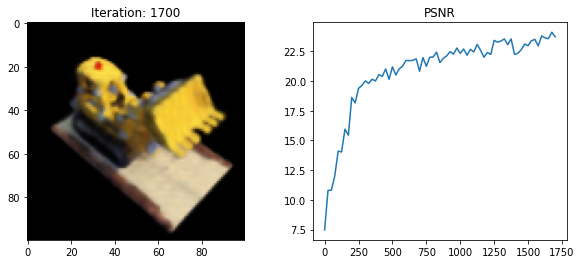

1725 0.6839449787139893 secs per iter


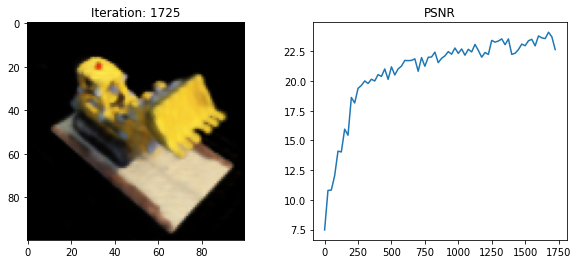

1750 0.6875135326385498 secs per iter


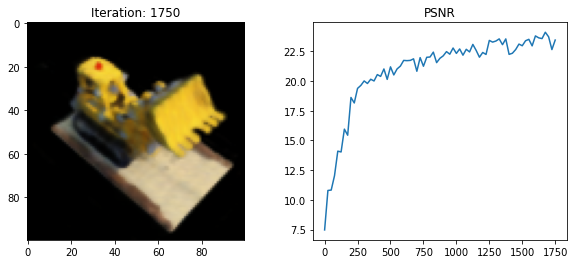

1775 0.6848299407958984 secs per iter


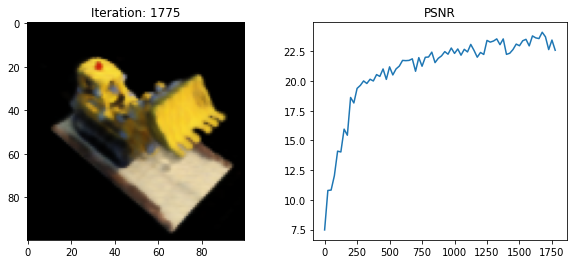

1800 0.6859621047973633 secs per iter


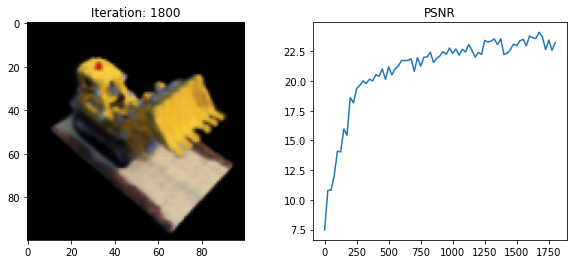

1825 0.6844103622436524 secs per iter


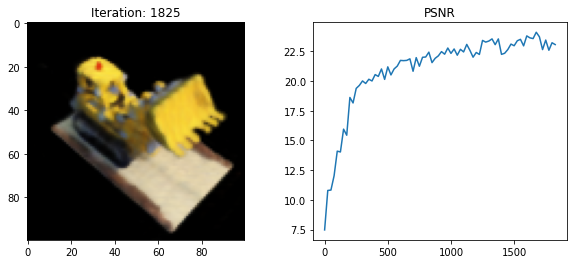

1850 0.6836963653564453 secs per iter


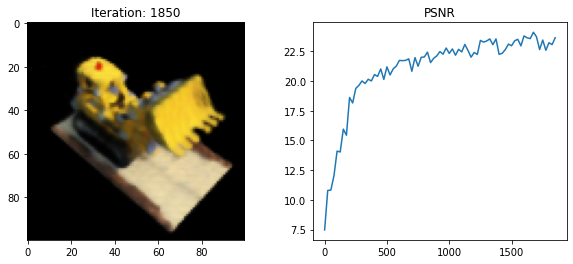

1875 0.6876722717285156 secs per iter


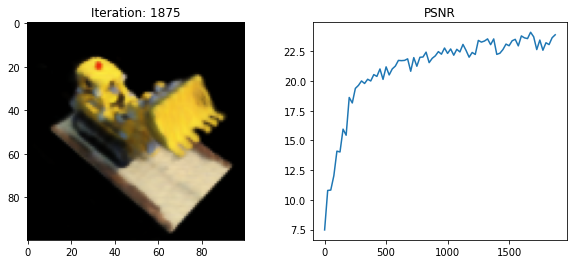

1900 0.7196200847625732 secs per iter


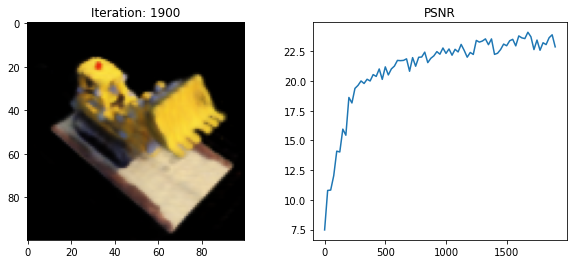

1925 0.6825112247467041 secs per iter


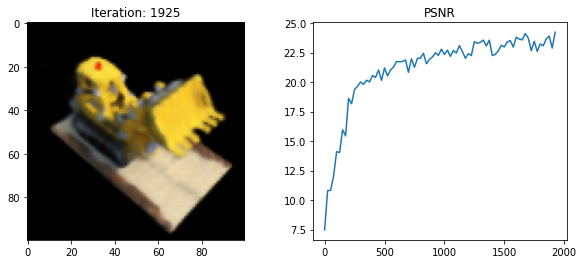

1950 0.6823687839508057 secs per iter


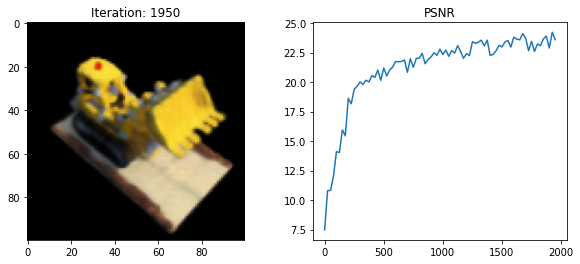

1975 0.681912899017334 secs per iter


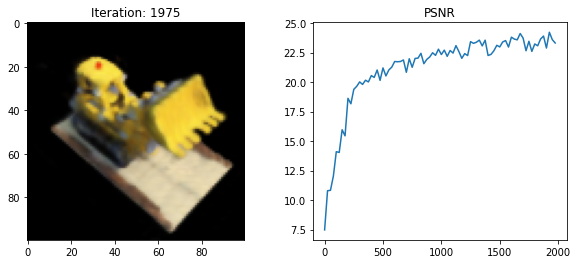

2000 0.6866108322143555 secs per iter


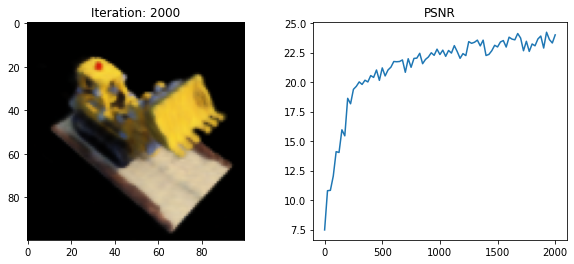

2025 0.6827495861053466 secs per iter


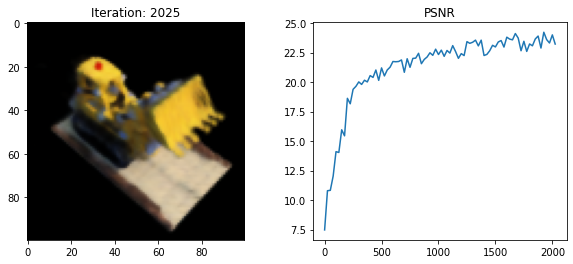

2050 0.6832527446746827 secs per iter


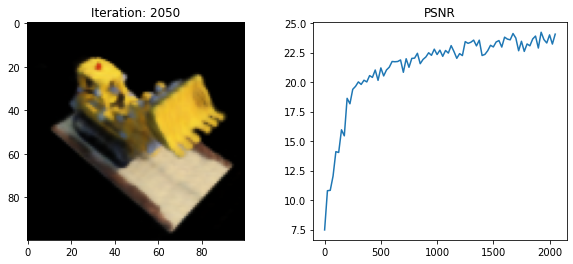

2075 0.6885844612121582 secs per iter


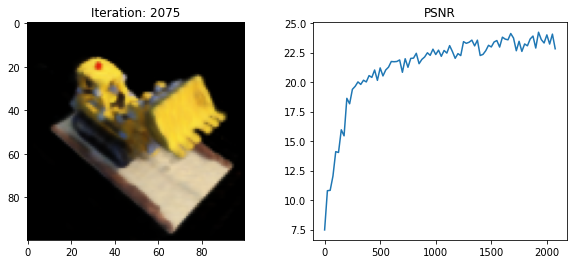

2100 0.6849110317230225 secs per iter


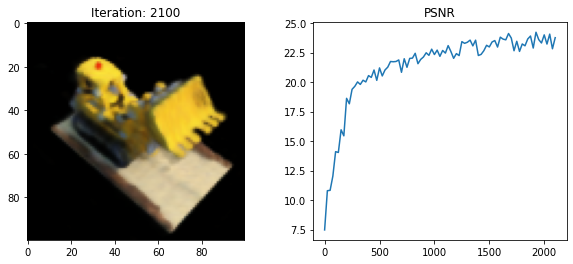

2125 0.6888859176635742 secs per iter


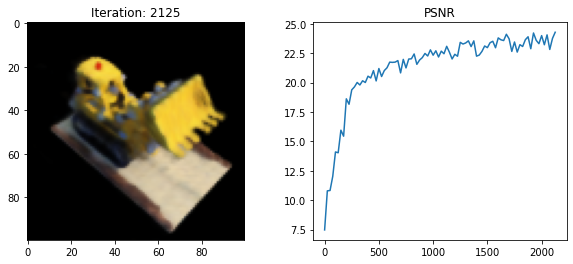

2150 0.6845546913146973 secs per iter


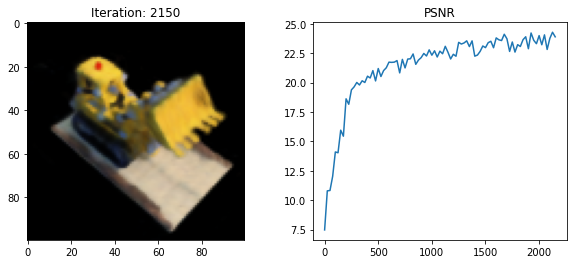

2175 0.6854805374145507 secs per iter


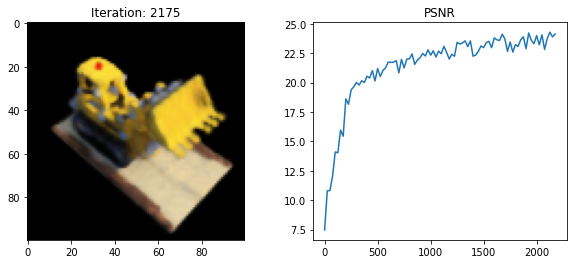

2200 0.6852989292144775 secs per iter


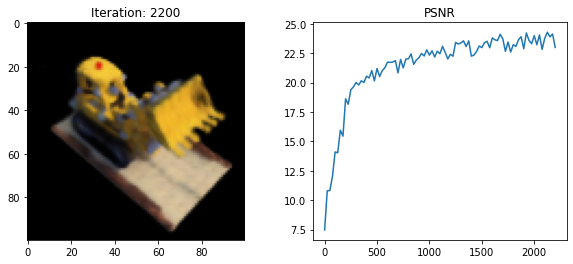

2225 0.6861339855194092 secs per iter


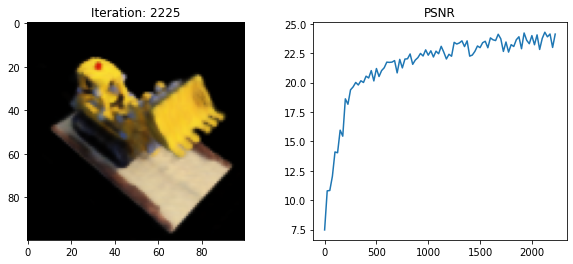

2250 0.6885123825073243 secs per iter


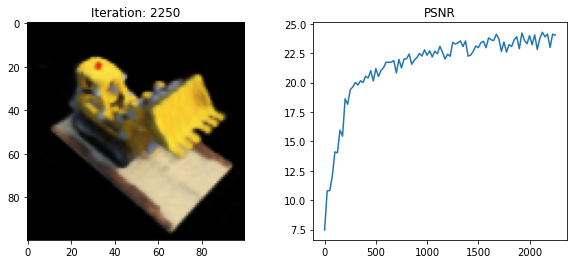

2275 0.6858698940277099 secs per iter


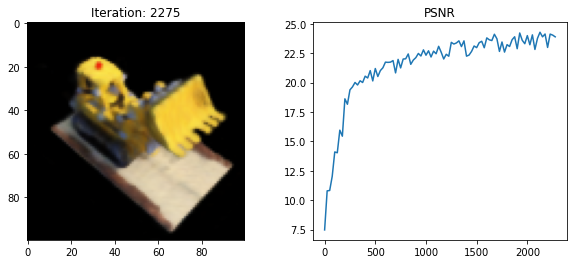

2300 0.6844402122497558 secs per iter


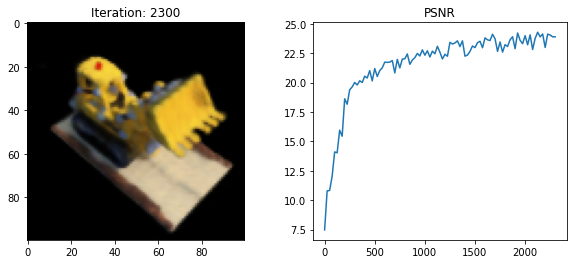

2325 0.6841251182556153 secs per iter


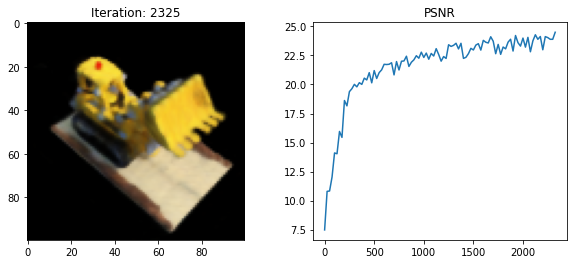

2350 0.6833700275421143 secs per iter


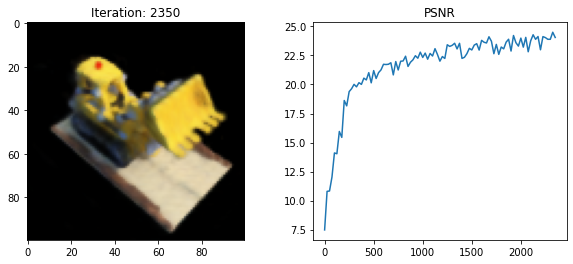

2375 0.689257001876831 secs per iter


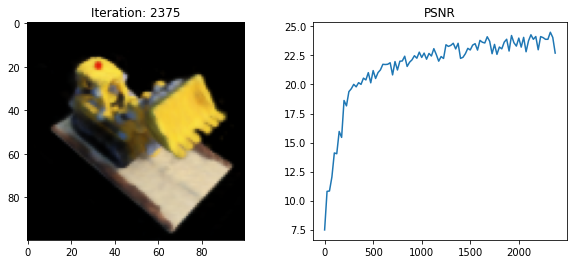

2400 0.6853466796875 secs per iter


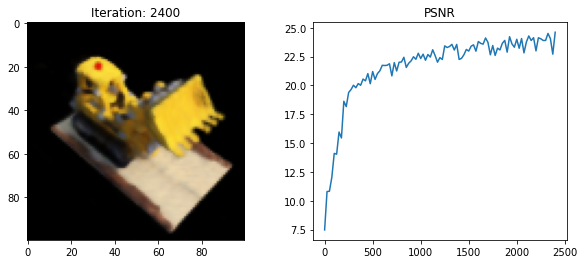

2425 0.6831692028045654 secs per iter


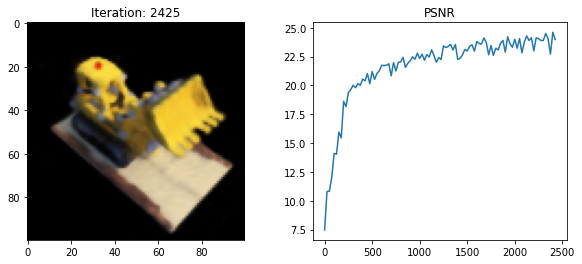

2450 0.6842771434783935 secs per iter


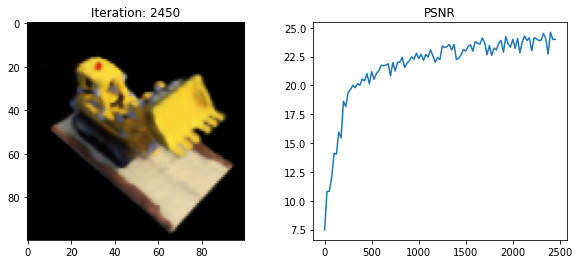

2475 0.6852435970306396 secs per iter


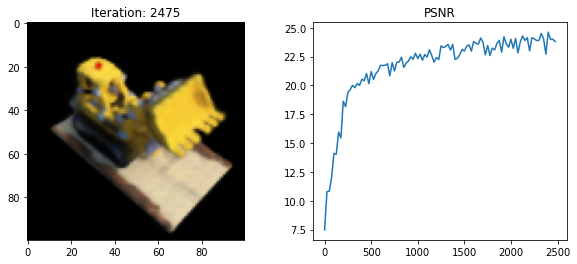

2500 0.68682373046875 secs per iter


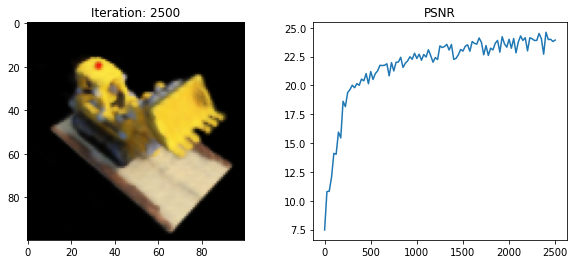

2525 0.68509428024292 secs per iter


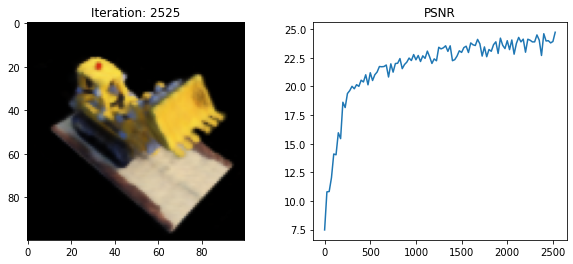

2550 0.6845382022857666 secs per iter


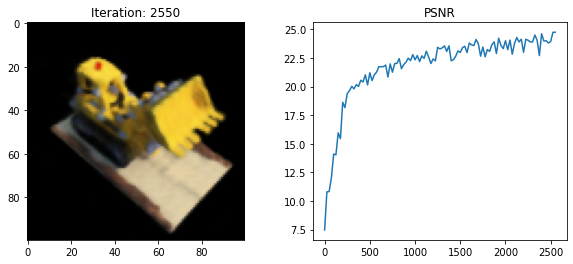

2575 0.6848665142059326 secs per iter


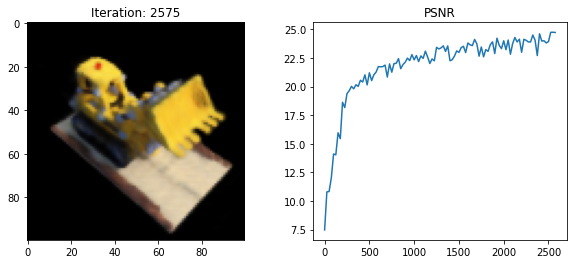

2600 0.7131631565093994 secs per iter


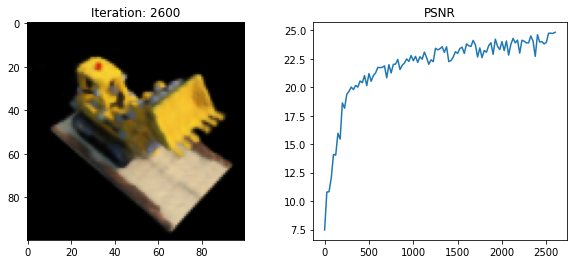

2625 0.6862436676025391 secs per iter


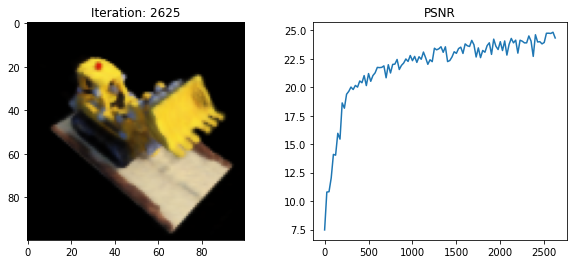

2650 0.6841201210021972 secs per iter


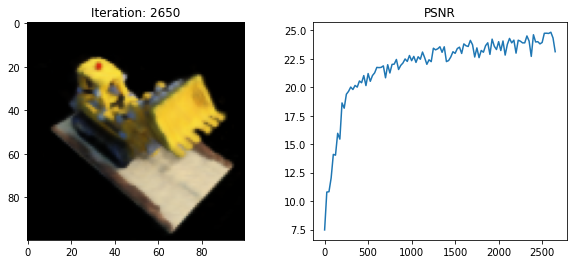

2675 0.6862491703033448 secs per iter


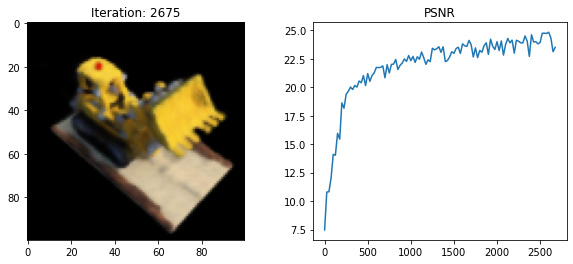

2700 0.6836712455749512 secs per iter


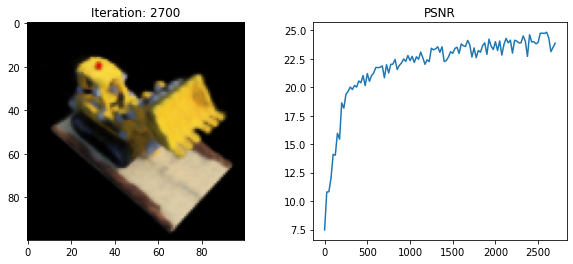

2725 0.683060131072998 secs per iter


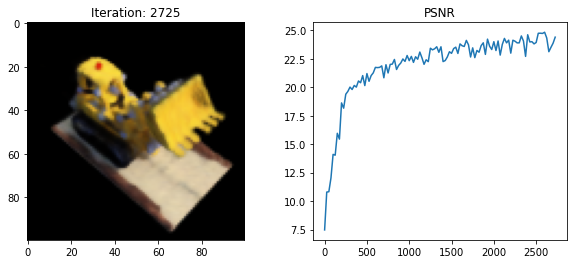

2750 0.6922996234893799 secs per iter


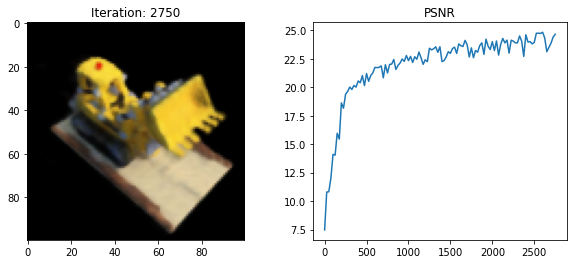

2775 0.682521505355835 secs per iter


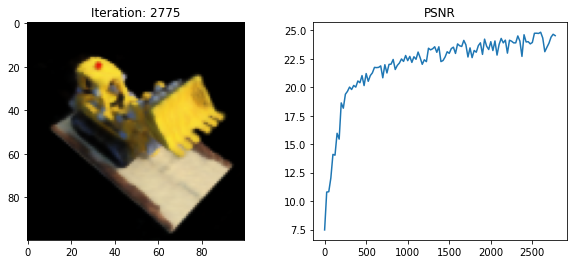

2800 0.6968019390106202 secs per iter


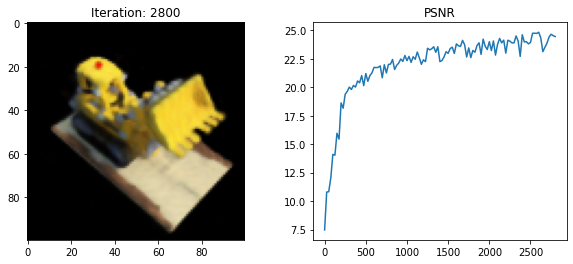

2825 0.6858515644073486 secs per iter


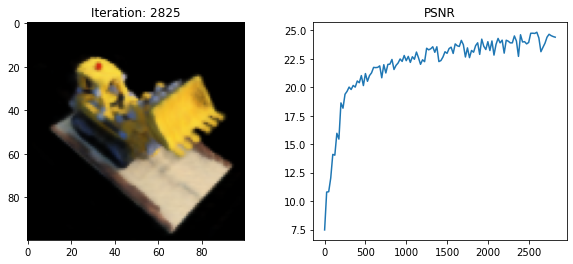

2850 0.686837797164917 secs per iter


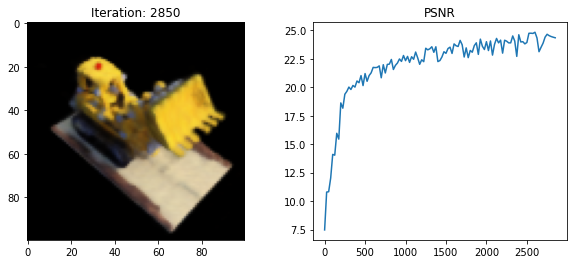

2875 0.6965372467041016 secs per iter


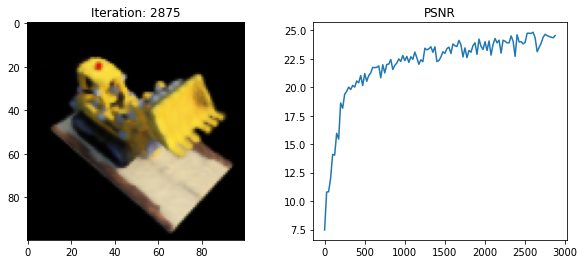

2900 0.6879258918762207 secs per iter


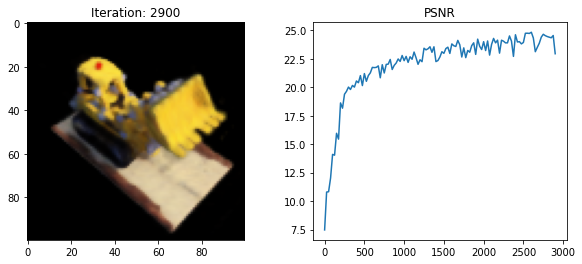

2925 0.6843181324005126 secs per iter


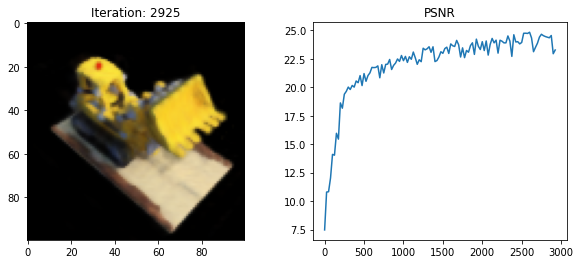

2950 0.6858013534545898 secs per iter


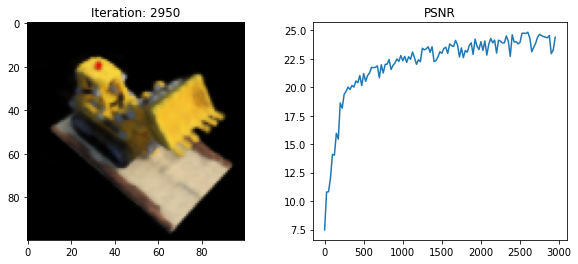

2975 0.6851229095458984 secs per iter


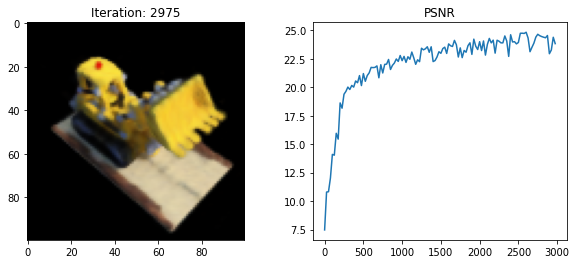

3000 0.6870844078063965 secs per iter


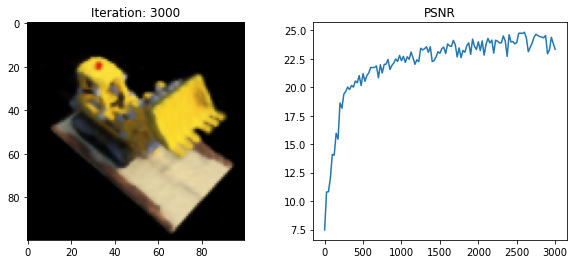

Done


In [ ]:
model = init_model()
optimizer = tf.keras.optimizers.Adam(5e-4)

N_samples = 64
N_iters = 3000
psnrs = []
iternums = []
i_plot = 25

import time
t = time.time()
for i in range(N_iters+1):
    
    img_i = np.random.randint(images.shape[0])
    target = images[img_i]
    pose = poses[img_i]
    rays_o, rays_d = get_rays(H, W, focal, pose)
    with tf.GradientTape() as tape:
        rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples, rand=True)
        loss = tf.reduce_mean(tf.square(rgb - target))
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    if i%i_plot==0:
        print(i, (time.time() - t) / i_plot, 'secs per iter')
        t = time.time()
        
        # Render the holdout view for logging
        rays_o, rays_d = get_rays(H, W, focal, testpose)
        rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
        loss = tf.reduce_mean(tf.square(rgb - testimg))
        psnr = -10. * tf.math.log(loss) / tf.math.log(10.)

        psnrs.append(psnr.numpy())
        iternums.append(i)
        
        plt.figure(figsize=(10,4))
        plt.subplot(121)
        plt.imshow(rgb)
        plt.title(f'Iteration: {i}')
        plt.subplot(122)
        plt.plot(iternums, psnrs)
        plt.title('PSNR')
        plt.show()

print('Done')

# Interactive Visualization

In [ ]:
%matplotlib inline
from ipywidgets import interactive, widgets


trans_t = lambda t : tf.convert_to_tensor([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,t],
    [0,0,0,1],
], dtype=tf.float32)

rot_phi = lambda phi : tf.convert_to_tensor([
    [1,0,0,0],
    [0,tf.cos(phi),-tf.sin(phi),0],
    [0,tf.sin(phi), tf.cos(phi),0],
    [0,0,0,1],
], dtype=tf.float32)

rot_theta = lambda th : tf.convert_to_tensor([
    [tf.cos(th),0,-tf.sin(th),0],
    [0,1,0,0],
    [tf.sin(th),0, tf.cos(th),0],
    [0,0,0,1],
], dtype=tf.float32)


def pose_spherical(theta, phi, radius):
    c2w = trans_t(radius)
    c2w = rot_phi(phi/180.*np.pi) @ c2w
    c2w = rot_theta(theta/180.*np.pi) @ c2w
    c2w = np.array([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]]) @ c2w
    return c2w


def f(**kwargs):
    c2w = pose_spherical(**kwargs)
    rays_o, rays_d = get_rays(H, W, focal, c2w[:3,:4])
    rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
    img = np.clip(rgb,0,1)
    
    plt.figure(2, figsize=(20,6))
    plt.imshow(img)
    plt.show()
    

sldr = lambda v, mi, ma: widgets.FloatSlider(
    value=v,
    min=mi,
    max=ma,
    step=.01,
)

names = [
    ['theta', [100., 0., 360]],
    ['phi', [-30., -90, 0]],
    ['radius', [4., 3., 5.]],
]

interactive_plot = interactive(f, **{s[0] : sldr(*s[1]) for s in names})
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=100.0, description='theta', max=360.0, step=0.01), FloatSlider(value=-…

# Render 360 Video

In [ ]:
frames = []
for th in tqdm(np.linspace(0., 360., 120, endpoint=False)):
    c2w = pose_spherical(th, -30., 4.)
    rays_o, rays_d = get_rays(H, W, focal, c2w[:3,:4])
    rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
    frames.append((255*np.clip(rgb,0,1)).astype(np.uint8))

import imageio
f = 'video.mp4'
imageio.mimwrite(f, frames, fps=30, quality=7)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/120 [00:00<?, ?it/s]

In [ ]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('video.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls autoplay loop>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)